# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. A current [paper](https://www.pnas.org/doi/10.1073/pnas.2314853121) has already preprocessed the dataset and created homology reduced data splits. We will reuse these.

The downloaded data includes measurements of changes in the Gibbs free enrgy ($\Delta \Delta G $). 
This will be the value that you will have to predict for a given protein with a point mutation. 

Here we will use protein embeddings computed by ESM as input. 
We provide precomputed embeddings from the last layer of the smallest ESM model. You can adjust the Dataloader's code to load the embedding of the wild type or of the mutated sequence or both. You can use it however you like. This is just to provide you easy access to embeddings. If you want to compute your own embeddings from other layers or models you can do that, too. 

Below we provide you with a strcuture for the project that you can start with.  
Edit the cells to your liking and add more code to create your final model.


## Imports

In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.  
As mentioned, we provide embeddings from the last layer of ESM as input. You can access either the wild type or the mutated sequence and you could also further adjsut the embeddings. 
Here we have an embedding representing the complete sequence. It was computed by averaging over the embeddings per residue in the sequence. 

The ``Dataset`` classes return tuples of ``(embedding, ddg_value)``.

In [2]:
class ProtEmbeddingDataset(Dataset):
    """
    Dataset that returns (mut_embedding, wt_embedding, ddG_label).
    WT embedding is required; raises an error if missing.
    """
    def __init__(self, tensor_folder, csv_file, id_col="name", label_col="ddG_ML", layer=6):
        self.tensor_folder = tensor_folder
        self.layer = layer

        self.df = pd.read_csv(csv_file, sep=",")
        self.df = self.df[self.df.mut_type != "wt"].reset_index(drop=True)

        self.labels = torch.tensor(self.df[label_col].values, dtype=torch.float32)
        self.ids = self.df[id_col].values
        self.wt_names = self.df["WT_name"].values

    def __len__(self):
        return len(self.labels)

    def _load_emb(self, name: str, suffix: str | None = None):
        fname = f"{name}{suffix if suffix else ''}.pt"
        path = os.path.join(self.tensor_folder, fname)
        obj = torch.load(path, map_location="cpu")
        return obj["mean_representations"][self.layer].float()

    def __getitem__(self, idx):
        # mutant embedding (must exist)
        emb_mut = self._load_emb(self.ids[idx], suffix=None)

        # wildtype embedding: must exist with one of the suffixes
        wt_base = self.wt_names[idx]
        wt_path1 = os.path.join(self.tensor_folder, wt_base + "_wte.pt")
        wt_path2 = os.path.join(self.tensor_folder, wt_base + "_wty.pt")

        if os.path.exists(wt_path1):
            emb_wt = self._load_emb(wt_base, suffix="_wte")
        elif os.path.exists(wt_path2):
            emb_wt = self._load_emb(wt_base, suffix="_wty")
        else:
            raise FileNotFoundError(
                f"WT embedding missing for WT_name='{wt_base}' "
                f"(tried '{wt_base}_wte.pt' and '{wt_base}_wty.pt')"
            )

        label = self.labels[idx]
        return emb_mut, emb_wt, label

In [3]:
# usage 
# make sure to adjust the paths to where your files are located
dataset_train = ProtEmbeddingDataset('project_data/mega_train_embeddings', 'project_data/mega_train.csv')
dataset_val = ProtEmbeddingDataset('project_data/mega_val_embeddings', 'project_data/mega_val.csv')
# dataset_test = ProtEmbeddingDataset('project_data/mega_test_embeddings', 'project_data/mega_test.csv') # only once available

dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True, num_workers=16)
dataloader_val = DataLoader(dataset_val, batch_size=512, shuffle=False, num_workers=16)
# dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

/Users/jianzhouyao/Library/Mobile Documents/com~apple~CloudDocs/Universität/ETH/DL in Biology/Dry_Lab/bc_deep_learning_in_biology/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


## Model architecture and training

Now it's your turn. Create a model trained on the embeddings and the corresponding ddG values.  
Be aware that this is not a classification task, but a regression task. You want to predict a continuous number that is as close to the measured $\Delta \Delta G $ value as possible.
You will need to adjust your architecture and loss accordingly.

Train the model with the predefined dataloaders. And try to improve the model. 
Only test on the test set at the very end, when you have finished fine-tuning you model. 

In [4]:
# ── Linear Regression on mutant + wildtype embeddings ─────────────────────────
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# ── 1. Reinstantiate datasets (picks up the updated __getitem__ returning 3 values) ──
dataset_train = ProtEmbeddingDataset('project_data/mega_train_embeddings', 'project_data/mega_train.csv')
dataset_val   = ProtEmbeddingDataset('project_data/mega_val_embeddings',   'project_data/mega_val.csv')

dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True,  num_workers=0)
dataloader_val   = DataLoader(dataset_val,   batch_size=512,  shuffle=False, num_workers=0)

# ── 2. Extract all embeddings and labels from dataloaders ─────────────────────
def extract_embeddings(dataloader):
    X, Y = [], []
    for emb_mut, emb_wt, label in dataloader:
        combined = torch.cat([emb_mut, emb_wt], dim=-1)  # (batch, 1536)
        X.append(combined.numpy())
        Y.append(label.numpy())
    return np.concatenate(X), np.concatenate(Y)

print("Extracting train embeddings...")
X_train, y_train = extract_embeddings(dataloader_train)
print("Extracting val embeddings...")
X_val, y_val = extract_embeddings(dataloader_val)

print(f"X_train shape: {X_train.shape}")  # (215731, 1536)
print(f"y_train shape: {y_train.shape}")  # (215731,)

Extracting train embeddings...
Extracting val embeddings...
X_train shape: (215731, 1536)
y_train shape: (215731,)


Setting up XGBoost...
Training XGBoost (this will be fast on your M2 Pro)...
[0]	validation_0-rmse:0.92474
[50]	validation_0-rmse:0.89641
[100]	validation_0-rmse:0.87784
[145]	validation_0-rmse:0.87888
Training completed in 39.44 seconds!

XGBoost RMSE    : 0.8765
XGBoost Pearson : 0.3517
XGBoost Spearman: 0.3283


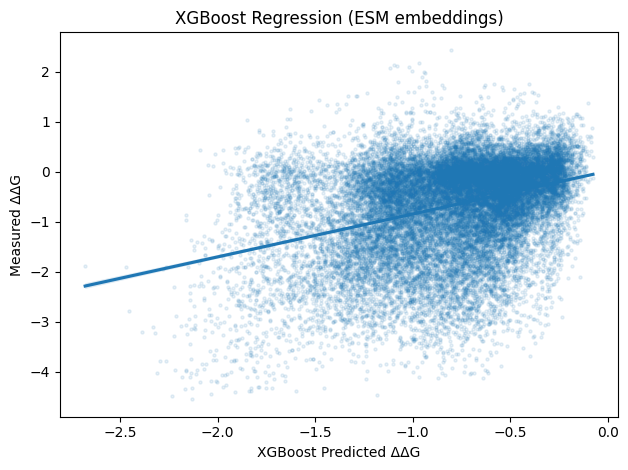

In [ ]:
# %%
# ── 2. Train XGBoost Regression (Optimized for Apple M2 Pro 8GB RAM) ──────────
import xgboost as xgb
import time
import numpy as np
import scipy.stats
import sklearn.metrics as skmetrics
import seaborn as sns
import matplotlib.pyplot as plt

# NOTE FOR 8GB RAM MACBOOK: 
# We DO NOT use StandardScaler here. Tree-based models don't need feature scaling.
# Skipping it saves ~1.3GB of RAM, preventing your Mac from heavily swapping memory.

print("Setting up XGBoost...")
start_time = time.time()

# 'hist' tree method is highly optimized for Apple Silicon and uses significantly less memory
model_xgb = xgb.XGBRegressor(
    n_estimators=500,            # Number of boosting rounds (trees)
    learning_rate=0.05,          # Step size
    max_depth=6,                 # Maximum tree depth
    tree_method='hist',          # CRITICAL: Fast & memory-efficient for Apple M2
    subsample=0.8,               # Use 80% of data per tree to prevent overfitting
    colsample_bytree=0.8,        # Use 80% of features per tree to save RAM
    n_jobs=-1,                   # Use all available CPU cores on your M2 Pro
    random_state=42,
    early_stopping_rounds=20     # Stop early if validation doesn't improve
)

print("Training XGBoost (this will be fast on your M2 Pro)...")
model_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], 
    verbose=50                   # Print progress every 50 rounds
)

print(f"Training completed in {(time.time() - start_time):.2f} seconds!")

# Predict on validation set
preds_xgb = model_xgb.predict(X_val)

# %%
# ── 3. Evaluate XGBoost ────────────────────────────────────────────────────────
rmse_xgb = np.sqrt(skmetrics.mean_squared_error(y_val, preds_xgb))
print(f"\nXGBoost RMSE    : {rmse_xgb:.4f}")
print(f"XGBoost Pearson : {scipy.stats.pearsonr(preds_xgb, y_val)[0]:.4f}")
print(f"XGBoost Spearman: {scipy.stats.spearmanr(preds_xgb, y_val)[0]:.4f}")

sns.regplot(x=preds_xgb, y=y_val, scatter_kws={"alpha": 0.1, "s": 5})
plt.xlabel("XGBoost Predicted ΔΔG")
plt.ylabel("Measured ΔΔG")
plt.title("XGBoost Regression (ESM embeddings)")
plt.tight_layout()
plt.show()

<mark>Incorporating the wildtype sequences in addition to the mutant sequences only marginally improved the metrics.</mark>

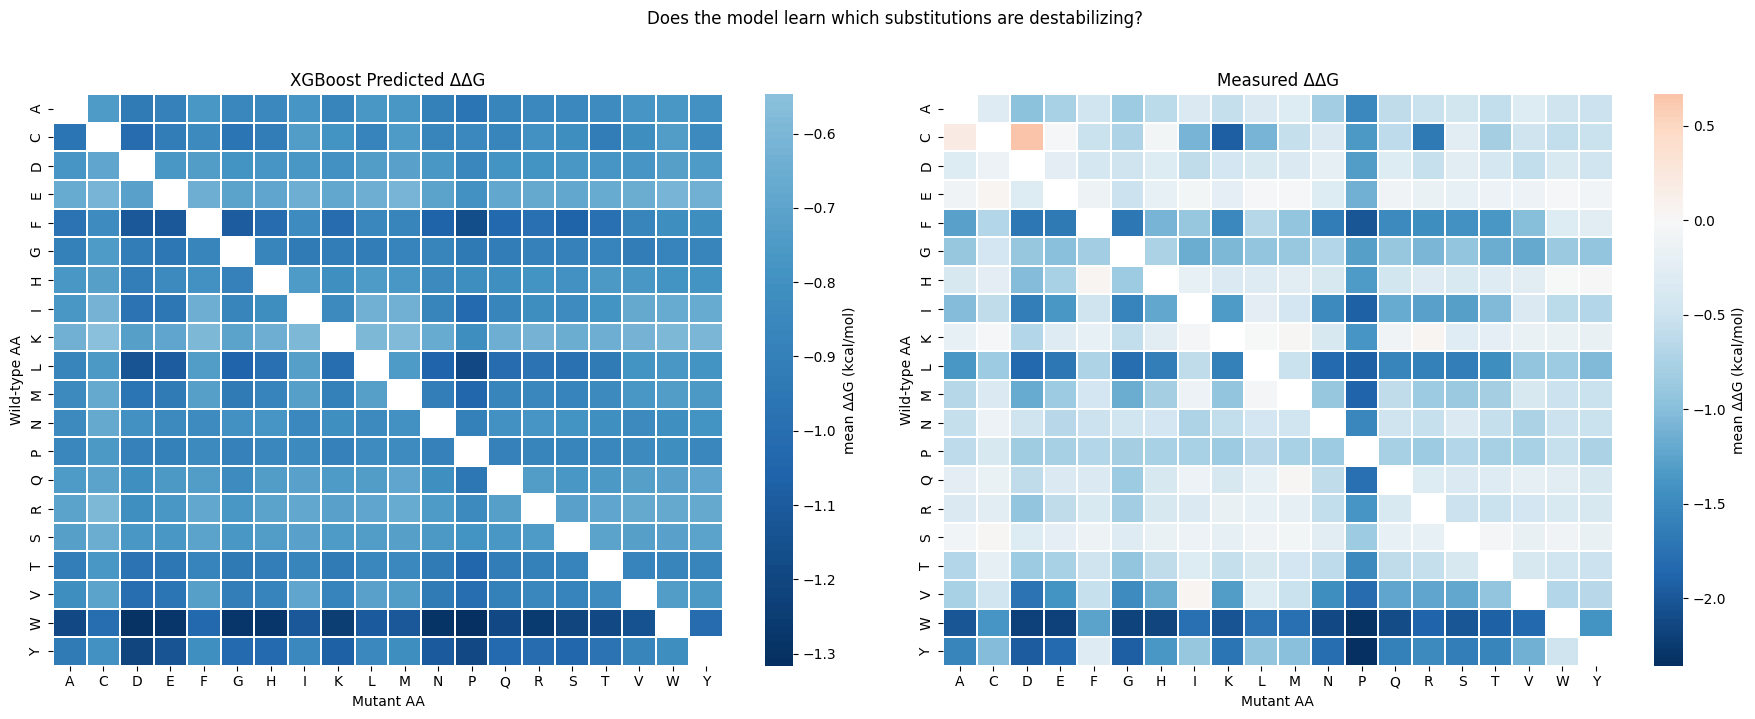

In [8]:
# %%
# ── Option A: Mean predicted ΔΔG per substitution type ────────────────────────
# Parse wt and mutant AA from the val dataframe
df_val_mut = pd.read_csv('project_data/mega_val.csv')
df_val_mut = df_val_mut[df_val_mut.mut_type != "wt"].copy()
df_val_mut["wt_aa"]  = df_val_mut["mut_type"].str[0]
df_val_mut["mut_aa"] = df_val_mut["mut_type"].str[-1]

# ---> CHANGED HERE: Now using XGBoost predictions instead of Ridge
df_val_mut["pred_ddG"] = preds_xgb  

# heatmap: mean predicted ΔΔG for each wt→mut substitution
pivot_pred = df_val_mut.groupby(["wt_aa", "mut_aa"])["pred_ddG"].mean().unstack()
pivot_true = df_val_mut.groupby(["wt_aa", "mut_aa"])["ddG_ML"].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for ax, pivot, title in zip(axes,
                             [pivot_pred, pivot_true],
                             ["XGBoost Predicted ΔΔG", "Measured ΔΔG"]):
    sns.heatmap(pivot, cmap="RdBu_r", center=0, ax=ax,
                linewidths=0.3, cbar_kws={"label": "mean ΔΔG (kcal/mol)"})
    ax.set_title(title)
    ax.set_xlabel("Mutant AA")
    ax.set_ylabel("Wild-type AA")

plt.suptitle("Does the model learn which substitutions are destabilizing?", y=1.02)
plt.tight_layout()
plt.show()

In [11]:
# %%
# ── 1. Define the PyTorch MLP Model ───────────────────────────────────────────
import torch
import torch.nn as nn
import torch.optim as optim
import math

class ProteinStabilityMLP(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=512):
        super().__init__()
        # Input: 768 (mutant) + 768 (wildtype) = 1536
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),             # GELU often outperforms ReLU in embedding tasks
            nn.Dropout(0.3),       # 30% dropout to prevent overfitting
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim // 2, 1) # Output: 1 continuous value (ΔΔG)
        )
        
    def forward(self, x):
        return self.network(x).squeeze(-1) # Output shape: (batch_size,)

# Check for Apple Silicon GPU (MPS)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🔥 Apple M2 GPU (MPS) is available and will be used!")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, using CPU.")

# Initialize model and move to M2 GPU
model_mlp = ProteinStabilityMLP().to(device)
print(model_mlp)

🔥 Apple M2 GPU (MPS) is available and will be used!
ProteinStabilityMLP(
  (network): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


/Users/jianzhouyao/Library/Mobile Documents/com~apple~CloudDocs/Universität/ETH/DL in Biology/Dry_Lab/bc_deep_learning_in_biology/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Neural Network Training...


Epoch 1/10 [Train]: 100%|██████████| 211/211 [01:41<00:00,  2.08it/s]


Epoch 01 | Train MSE: 0.7830 | Val MSE: 0.6787 | Val RMSE: 0.8238


Epoch 2/10 [Train]: 100%|██████████| 211/211 [01:35<00:00,  2.21it/s]


Epoch 02 | Train MSE: 0.6396 | Val MSE: 0.7585 | Val RMSE: 0.8709


Epoch 3/10 [Train]: 100%|██████████| 211/211 [01:37<00:00,  2.17it/s]


Epoch 03 | Train MSE: 0.6033 | Val MSE: 0.6909 | Val RMSE: 0.8312


Epoch 4/10 [Train]: 100%|██████████| 211/211 [01:35<00:00,  2.20it/s]


Epoch 04 | Train MSE: 0.5862 | Val MSE: 0.6876 | Val RMSE: 0.8292


Epoch 5/10 [Train]: 100%|██████████| 211/211 [01:33<00:00,  2.25it/s]


Epoch 05 | Train MSE: 0.5696 | Val MSE: 0.7304 | Val RMSE: 0.8546


Epoch 6/10 [Train]: 100%|██████████| 211/211 [01:36<00:00,  2.19it/s]


Epoch 06 | Train MSE: 0.5586 | Val MSE: 0.7069 | Val RMSE: 0.8408


Epoch 7/10 [Train]: 100%|██████████| 211/211 [01:38<00:00,  2.15it/s]


Epoch 07 | Train MSE: 0.5490 | Val MSE: 0.7778 | Val RMSE: 0.8819


Epoch 8/10 [Train]: 100%|██████████| 211/211 [01:35<00:00,  2.22it/s]


Epoch 08 | Train MSE: 0.5453 | Val MSE: 0.6703 | Val RMSE: 0.8187


Epoch 9/10 [Train]: 100%|██████████| 211/211 [01:34<00:00,  2.24it/s]


Epoch 09 | Train MSE: 0.5419 | Val MSE: 0.7029 | Val RMSE: 0.8384


Epoch 10/10 [Train]: 100%|██████████| 211/211 [01:37<00:00,  2.16it/s]


Epoch 10 | Train MSE: 0.5297 | Val MSE: 0.6907 | Val RMSE: 0.8311


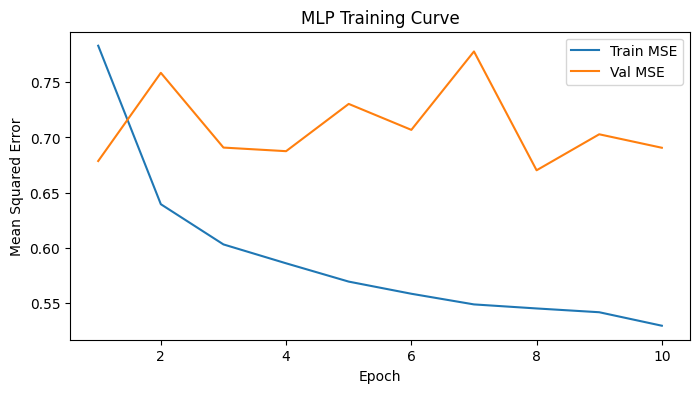

In [12]:
# %%
# ── 2. Train the MLP ──────────────────────────────────────────────────────────
from tqdm.auto import tqdm

# Hyperparameters
epochs = 10
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_mlp.parameters(), lr=learning_rate, weight_decay=1e-4)

# We recreate dataloaders to ensure fresh generators (RAM-friendly)
dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True, num_workers=0)
dataloader_val   = DataLoader(dataset_val, batch_size=512, shuffle=False, num_workers=0)

train_losses, val_losses = [], []

print("Starting Neural Network Training...")
for epoch in range(epochs):
    model_mlp.train()
    running_loss = 0.0
    
    # Train pass
    for emb_mut, emb_wt, labels in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        # Combine embeddings and move to GPU
        inputs = torch.cat([emb_mut, emb_wt], dim=-1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        predictions = model_mlp(inputs)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_train_loss = running_loss / len(dataset_train)
    train_losses.append(epoch_train_loss)
    
    # Validation pass
    model_mlp.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for emb_mut, emb_wt, labels in dataloader_val:
            inputs = torch.cat([emb_mut, emb_wt], dim=-1).to(device)
            labels = labels.to(device)
            
            predictions = model_mlp(inputs)
            loss = criterion(predictions, labels)
            running_val_loss += loss.item() * inputs.size(0)
            
    epoch_val_loss = running_val_loss / len(dataset_val)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1:02d} | Train MSE: {epoch_train_loss:.4f} | Val MSE: {epoch_val_loss:.4f} | Val RMSE: {math.sqrt(epoch_val_loss):.4f}")

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), train_losses, label='Train MSE')
plt.plot(range(1, epochs+1), val_losses, label='Val MSE')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("MLP Training Curve")
plt.legend()
plt.show()

Evaluating: 100%|██████████| 54/54 [00:12<00:00,  4.30it/s]



MLP RMSE    : 0.8311
MLP Pearson : 0.4850
MLP Spearman: 0.4464


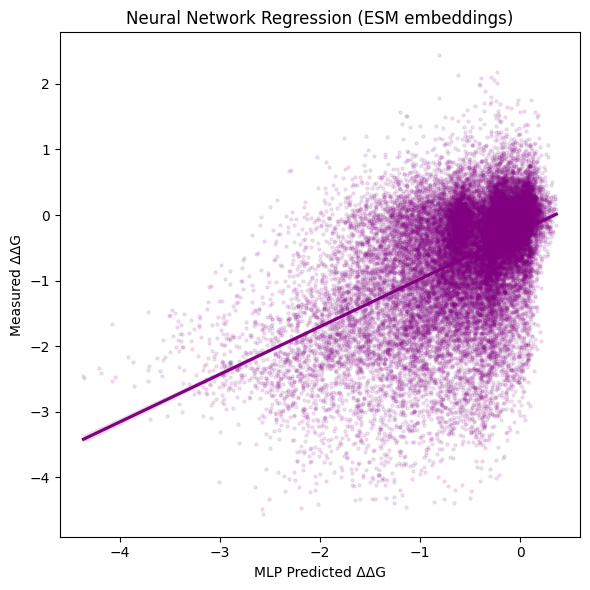

In [13]:
# %%
# ── 3. Evaluate the MLP and Visualize ─────────────────────────────────────────
import scipy.stats
import sklearn.metrics as skmetrics

model_mlp.eval()
all_preds = []
all_labels = []

# Gather all predictions
with torch.no_grad():
    for emb_mut, emb_wt, labels in tqdm(dataloader_val, desc="Evaluating"):
        inputs = torch.cat([emb_mut, emb_wt], dim=-1).to(device)
        preds = model_mlp(inputs)
        
        # Move back to CPU and convert to numpy for Scikit-Learn
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.numpy())

preds_mlp = np.concatenate(all_preds)
y_val_mlp = np.concatenate(all_labels)

# Metrics
rmse_mlp = np.sqrt(skmetrics.mean_squared_error(y_val_mlp, preds_mlp))
pearson_mlp, _ = scipy.stats.pearsonr(preds_mlp, y_val_mlp)
spearman_mlp, _ = scipy.stats.spearmanr(preds_mlp, y_val_mlp)

print(f"\nMLP RMSE    : {rmse_mlp:.4f}")
print(f"MLP Pearson : {pearson_mlp:.4f}")
print(f"MLP Spearman: {spearman_mlp:.4f}")

# Scatter Plot
plt.figure(figsize=(6, 6))
sns.regplot(x=preds_mlp, y=y_val_mlp, scatter_kws={"alpha": 0.1, "s": 5}, color="purple")
plt.xlabel("MLP Predicted ΔΔG")
plt.ylabel("Measured ΔΔG")
plt.title("Neural Network Regression (ESM embeddings)")
plt.tight_layout()
plt.show()

## Heatmap Interpretation: Does the model learn biochemistry?

> **Sign convention:** negative ΔΔG = destabilizing, positive ΔΔG = stabilizing.
> Dark blue = destabilizing, pink/red = stabilizing.

> The authors switched the signs when creating the dataset!

### What the model gets right
- **C (Cysteine) row** — correctly predicts that mutating away from Cys is strongly
  destabilizing (dark blue). Cys often forms disulfide bonds critical for structural
  stability; replacing it with almost any other amino acid breaks this bond.
- **W and Y rows** — model correctly learns that mutating away from large aromatic
  residues (Trp, Tyr) is destabilizing. These residues often occupy buried hydrophobic
  cores and contribute strongly to folding stability.
- **General sign** — both heatmaps are predominantly blue (negative ΔΔG), meaning the
  model correctly learns the dataset-wide bias: most random mutations are destabilizing,
  consistent with the well-established biological principle that proteins are already
  near-optimally evolved.

### Where the model falls short
- **Smoothness** — the predicted heatmap is far more uniform than the measured one.
  The model regresses toward the mean, missing sharp per-substitution effects
  (e.g. the strong column-specific patterns visible in the measured heatmap).
- **Missing column structure** — the measured heatmap shows clear *mutant AA* effects
  (e.g. mutating *to* **P/proline** is consistently destabilizing across all wt AAs,
  visible as a dark blue column). This makes biological sense — proline is a helix
  breaker that introduces rigidity. The linear model does not capture this.

### Conclusion
The linear model has learned a **global average effect per wild-type AA** but lacks
the resolution to capture position- or mutant-specific biochemistry. This motivates
moving to a nonlinear model (MLP) that can learn more complex substitution interactions.

## Validation and visualization

To get a good feeling of how the model is performing and to compare with literature, compute the Pearson and Spearman correlations.
You can also plot the predictions in a scatterplot. We have added some code for that. 

## Interpretation

Try to analyse and interpret your model and/or predictions in the context of the biological question.

## Performance on the test set

At the very end, after choosing your best model, see how well it performs on the test set.